## Chapter 4: [Spectroscopy](Spectroscopy.ipynb)

<hr style="height:1px;border-top:4px solid #FF8200" />

# Analysis of Core-Loss Spectra


part of 

## [Analysis of Transmission Electron Microscope Data](_Analysis_of_Transmission_Electron_Microscope_Data.ipynb)



by Gerd Duscher, 2019

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes



## Content

Qunatitative determination of composition in a core-loss EELS spectrum

Please cite:

[M. Tian et  al. *Measuring the areal density of nanomaterials by electron energy-loss spectroscopy*
Ultramicroscopy Volume 196, 2019, pages 154-160](https://doi.org/10.1016/j.ultramic.2018.10.009)

as a reference of this quantification method.

## First we import the relevant packages

In [5]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
%pylab --no-import-all notebook
%gui qt

from scipy.ndimage.filters import gaussian_filter

# import pyTEMlib packages
import pyTEMlib
import pyTEMlib.file_tools  as ft     # File input/ output library
import pyTEMlib.EELS_tools  as eels 

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)

Populating the interactive namespace from numpy and matplotlib
pyTEM version:  0.11.2019.3


# Load and plot a spectrum

As an example we load the spectrum **1EELS Acquire (high-loss).dm3** from the *example data* folder.

Please see [Loading an EELS Spectrum](LoadEELS.ipynb) for details on storage and plotting.

<IPython.core.display.Javascript object>


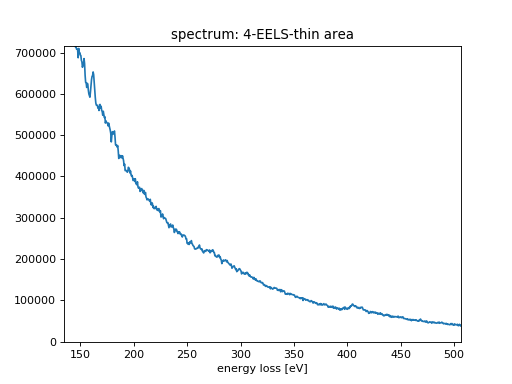

In [9]:
# Load file
try:
    h5_file.close()
except:
    pass
h5_file = ft.h5open_file()#os.path.join(current_directory,filename))
current_channel = h5_file['Measurement_000/Channel_000']

# get dictionary from current channel in pyUSID file
tags = ft.h5_get_dictionary(current_channel)
energy_scale_orig = tags['energy_scale']

# plot data
if tags['data_type']== 'EELS_spectrum':
    plt.figure()
    plt.plot(tags['energy_scale']-50,tags['data']);
    plt.title('spectrum: '+tags['title'])
    plt.xlabel('energy loss [eV]')
    plt.ylim(0);

else:
    print('NOT what we want here')
    if tags['data_type']== 'spectrum_image':
        tags['image'] = tags['data']
        tags['data'] = tags['cube'][0,0,:]
    ft.h5_plot(current_channel)
    

dict_keys(['aberrations', 'acceleration_voltage', 'camera_length', 'collection_angle', 'convergence_angle', 'exposure_spectrum', 'image_type', 'integration_time', 'machine_id', 'number_of_frames', 'platform', 'pyUSID_version', 'time_last_modified', 'timestamp', 'title', 'data_type', 'data', 'spectral_scale_x', 'spectral_units_x', 'spectral_origin_x', 'spectral_size_x', 'energy_scale'])
0.5


<IPython.core.display.Javascript object>


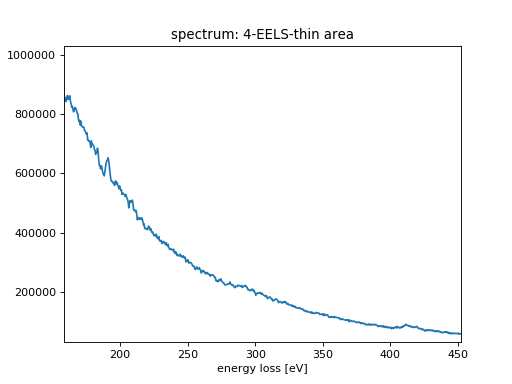

0.4539614561027837


In [26]:
print(tags.keys())
print(tags['spectral_scale_x'])
energy_scale = np.linspace(0,1023,1024)* 0.454 + tags['spectral_origin_x']-7
plt.figure()
plt.plot(energy_scale,tags['data']);
plt.title('spectrum: '+tags['title'])
plt.xlabel('energy loss [eV]')
plt.ylim(0);

print((400-188)/(768-301))

## Probability scale of y-axis

We need to know the total amount of electrons involved in the EELS spectrum 

There are three possibilities:
- the intensity of the low loss will give us the counts per acquisition time
- the intensity of the beam in an image (i.e. "Ronchigram" of vacuum)
- a direct measurement of the incident beam current

Here we got the low-loss spectrum. For the example please load **1EELS Acquire (low-loss).dm3** from the *example data* folder.

In [27]:
ll_channel = ft.h5_add_channel(h5_file,current_channel,'LL',filename=None)

# get dictionary from current channel in pyUSID file
LLspectrum_tags = ft.h5_get_dictionary(ll_channel)

print(f"{LLspectrum_tags['data'].sum():.0f} counts in  {LLspectrum_tags['integration_time']:.2f}sec")
I0 = LLspectrum_tags['data'].sum()/LLspectrum_tags['integration_time']
print(f"integration time for spectrum was {tags['integration_time']:.2f} s ")

I0 = LLspectrum_tags['data'].sum()/LLspectrum_tags['integration_time']*tags['integration_time']
print(f"incident beam current of core--loss is {I0:.0f} counts")

if 'incident_beam_current_counts' in current_channel:
    current_channel['incident_beam_current_counts'][()] = I0
    tags['intentsity_scale_ppm'] = 1e6/I0
    current_channel['intentsity_scale_ppm'][()] = tags['intentsity_scale_ppm']
else:
    current_channel['incident_beam_current_counts'] = I0
    tags['intentsity_scale_ppm'] = 1e6/I0
    current_channel['intentsity_scale_ppm'] = tags['intentsity_scale_ppm']

    
out_tags ={}
out_tags['intentsity_scale_ppm'] = tags['intentsity_scale_ppm']
if 'intentsity_scale_ppm' in current_channel:
    current_channel['intentsity_scale_ppm'][()] = tags['intentsity_scale_ppm']
else:
    current_channel['intentsity_scale_ppm'] = tags['intentsity_scale_ppm']


TypeError: Can't convert element 0 (L) to hsize_t

In [28]:
ll_channel = ft.h5_add_channel(h5_file,current_channel,'image',filename=None)

# get dictionary from current channel in pyUSID file
LLspectrum_tags = ft.h5_get_dictionary(ll_channel)


TypeError: Can't convert element 0 (i) to hsize_t

dict_keys(['aberrations', 'acceleration_voltage', 'camera_length', 'image_type', 'time_last_modified', 'title', 'data_type', 'data', 'spatial_size_x', 'spatial_size_y', 'spatial_scale_x', 'spatial_scale_y', 'FOV_x', 'FOV_y', 'extent', 'spatial_units', 'integration_time'])
-1365832057
2929135239.0 2372424700.0 0.8099403101681096
2929135239 counts in  1.00sec
integration time for spectrum was 40.00 s 
incident beam current of core--loss is 117165409560 counts


<IPython.core.display.Javascript object>


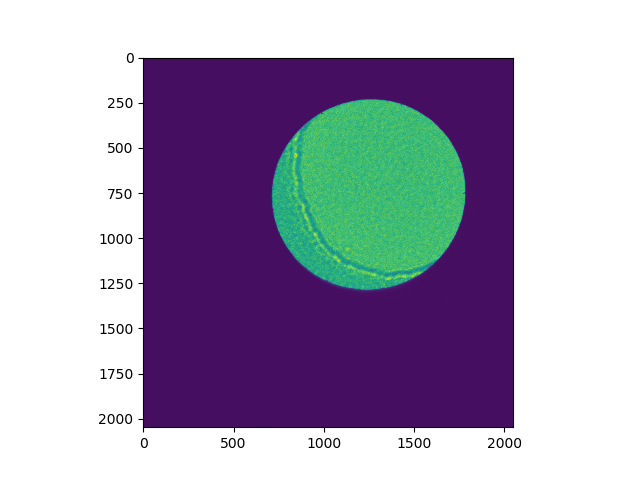

0 8.534942213366339e-06


In [27]:
print(LLspectrum_tags.keys())
print(LLspectrum_tags['data'].sum())
data = np.array(LLspectrum_tags['data'], dtype = float)

print(data.sum(),tags['data'].sum(), tags['data'].sum()/data.sum())
LLspectrum_tags['integration_time'] = 1
print(f"{data.sum():.0f} counts in  {LLspectrum_tags['integration_time']:.2f}sec")

print(f"integration time for spectrum was {tags['integration_time']:.2f} s ")

I0 = data.sum()/LLspectrum_tags['integration_time']*tags['integration_time']
print(f"incident beam current of core--loss is {I0:.0f} counts")
plt.figure()
plt.imshow(LLspectrum_tags['data'])
tags['intentsity_scale_ppm'] = 1e6/I0
      
out_tags ={}
out_tags['intentsity_scale_ppm'] = tags['intentsity_scale_ppm']
if 'intentsity_scale_ppm' in current_channel:
    current_channel['intentsity_scale_ppm'][()] = tags['intentsity_scale_ppm']
else:
    current_channel['intentsity_scale_ppm'] = tags['intentsity_scale_ppm']
print(current_channel['intentsity_scale_ppm'][()],tags['intentsity_scale_ppm'])

dict_keys(['aberrations', 'acceleration_voltage', 'camera_length', 'image_type', 'time_last_modified', 'title', 'data_type', 'data', 'spatial_size_x', 'spatial_size_y', 'spatial_scale_x', 'spatial_scale_y', 'FOV_x', 'FOV_y', 'extent', 'spatial_units', 'integration_time'])


<IPython.core.display.Javascript object>


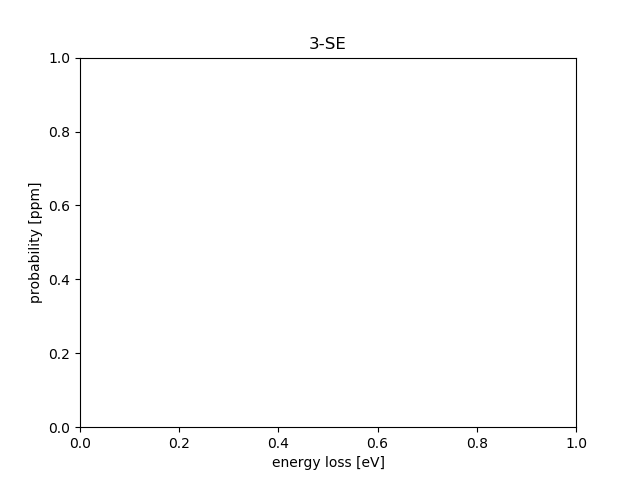

In [6]:
print(LLspectrum_tags.keys())

plt.figure()
plt.title(LLspectrum_tags['title'])
#plt.plot(LLspectrum_tags['energy_scale'] , LLspectrum_tags['data'] );
plt.xlabel('energy loss [eV]')
plt.ylabel('probability [ppm]');


## Intensity to Probability Calibration

 We need to calibrate the number of counts with the integration time of the spectrum.

<IPython.core.display.Javascript object>


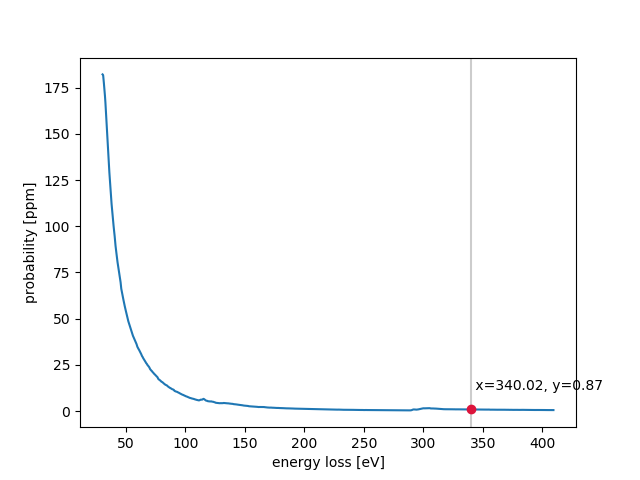

In [7]:
if 'intentsity_scale_ppm' not in current_channel:
    current_channel['intentsity_scale_ppm'] = 1
else:
    current_channel['intentsity_scale_ppm'][()] = 1

spectrum = tags['data']*tags['intentsity_scale_ppm']
plt.figure()
plt.plot(tags['energy_scale'], spectrum)
plt.xlabel('energy loss [eV]')
plt.ylabel('probability [ppm]');


## Which elements are present

To determine which elements are present we add a cursor to the above plot (see [Working with Cross-Sections](CH4-Working_with_X-Sections.ipynb) for details) and with a left (right) mouse-click, we will get the major (all) edges in the vincinity of the cursor.

In the example we note that the N-K edge of this boron nitride sample is not at 400keV. We have to adjust the energy-scale. <br>(THIS SHOULD NOT HAPPEN IN NORMAL SPECTRA AND IS FOR DEMONSTRATION ONLY)

In [8]:
maximal_chemical_shift = 5
cursor = eels.EdgesatCursor(plt.gca(), tags['energy_scale'],spectrum,maximal_chemical_shift)


Let's correct the energy scale of the example spectrum.

Again a shift of the energy scale is normal but not a discripancy of the dispersion.

## Declaration of Edges
Here, we declare which ionization-edges are present. Please make sure that the energy scale is correct!!!

Also the importance of the collection angle cannot be overstated.

In [ ]:
spectrum = tags['data']
## Input
edges_present = ['B-K','C-K','N-K']
tags['collection_angle'] = 10
print(tags['collection_angle'])

tags['energy_scale'] = np.linspace(0,1023,1024)* 0.454 + tags['spectral_origin_x']-7#energy_scale_orig-10#*1.04-8
energy_scale = tags['energy_scale']


edges = eels.make_edges(edges_present, energy_scale, tags['acceleration_voltage'], tags['collection_angle'])

plt.figure()
plt.plot(energy_scale, spectrum, label='spectrum')
plt.xlabel('energy-loss [eV]')
plt.ylabel('probability [ppm]');  

plot_edges= []
for key in edges:
    plot_edges.append( eels.elemental_edges(plt.gca(), edges[key]['Z']))

## Preparing the fitting mask

Our theoretical cross sections do not include any solid state effects (band structure) and so the fine structure at the onset of the spectra must be omitted in a quantification.

These parts of the spectrum will be simply set to zero. We plot the masked spectrum that will be evaluated.

<IPython.core.display.Javascript object>


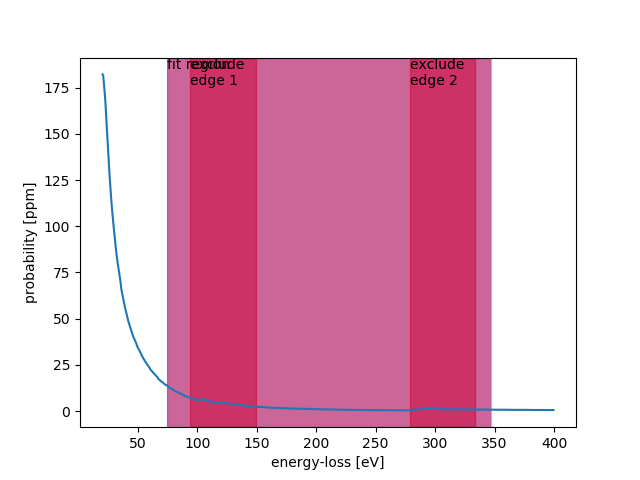

In [35]:
plt.figure()
plt.plot(energy_scale, spectrum, label='spectrum')
plt.xlabel('energy-loss [eV]')
plt.ylabel('probability [ppm]');  

regions = eels.Region_Selector(plt.gca())

for key in edges:
    regions.set_regions(str(key),edges[key]['onset']-edges[key]['start_exclude'], edges[key]['start_exclude']+edges[key]['end_exclude'])
                                  
regions.set_regions('fit region',energy_scale[100], tags['energy_scale'][-1]-energy_scale[100])



## The Fit

The function **model** just sums the weighted cross-sections and the background.

The background consists of the power-lawbackground before plus a polynomial component allowing for *a variation of the exponent $r$ of the power-law*.

The least square fit is weighted by the noise according to Poison statistic $\sqrt{I(\Delta E)}$.



In [36]:
region_tags = regions.get_regions()
p = eels.fit_edges(spectrum, energy_scale, region_tags, edges)

print(p)
print(f"{edges['1']['element']}/{edges['2']['element']} ratio is {edges['1']['areal_density']/edges['2']['areal_density']:.3f}")

#the B atom areal density of a single layer of h-BN (18.2 nm−2) 
#for key in edges:
#    if key.isdigit():
#        print(f"{edges[key]['element']} ({edges[key]['Z']}) areal density is {edges[key]['areal_density']:.0f} atoms per square nm, which equates {abs(edges[key]['areal_density'])/18.2:.1f} atomic layers")


{'1': {'Z': 14, 'symmetry': 'L3', 'element': 'Si', 'chemcial_shift': 0, 'original_onset': 99.2, 'onset': 99.2, 'start_exclude': 5, 'end_exclude': 50, 'data': array([2.00757279e-08, 1.97434517e-08, 1.94111755e-08, ...,
       7.74158328e-10, 7.72894411e-10, 7.71630495e-10]), 'areal_density': 34255060.369413234}, '2': {'Z': 6, 'symmetry': 'K1', 'element': 'C', 'chemcial_shift': 0, 'original_onset': 283.8, 'onset': 283.8, 'start_exclude': 5, 'end_exclude': 50, 'data': array([2.62583579e-07, 2.56892199e-07, 2.51200820e-07, ...,
       5.21395028e-10, 5.20541210e-10, 5.19687393e-10]), 'areal_density': 1.6892296069364026}, 'model': {'background': array([510.53883601, 497.8536099 , 485.59343316, ...,   1.30068083,
         1.30285564,   1.30503265]), 'background-poly_0': 0.552572804854685, 'background-poly_1': -0.009554339227605096, 'background-poly_2': 2.7814643159616946e-05, 'background-A': 2199292.28330108, 'background-r': 2.777832587101116, 'spectrum': array([511.22653173, 498.52992347, 4

## Plotting of the fit


<IPython.core.display.Javascript object>


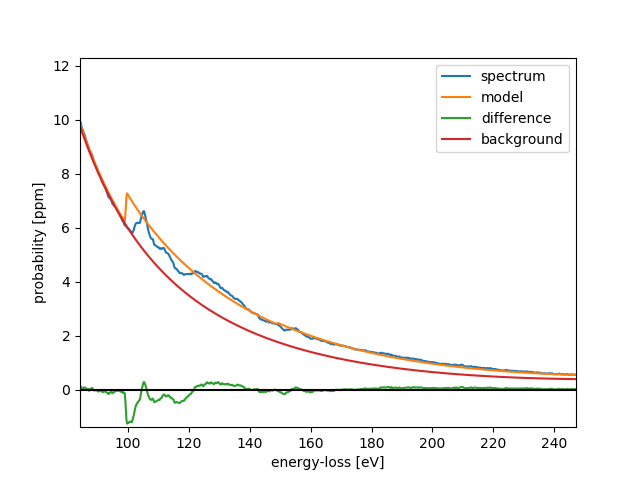

In [37]:



plt.figure()
plt.plot(energy_scale, spectrum, label='spectrum')
plt.plot(energy_scale,edges['model']['spectrum'], label='model')
plt.plot(energy_scale,spectrum-edges['model']['spectrum'], label='difference')
plt.plot(energy_scale,edges['model']['background'], label='background')
plt.plot([energy_scale[0],energy_scale[-1]],[0,0],c='black')

plt.xlabel('energy-loss [eV]')
plt.ylabel('probability [ppm]')
plt.legend();

In [40]:
si_area = 19196041/1e6

si_vol = 8/0.513**3  
si_mono=   4/(0.92*0.531)*2
print(si_mono)
print( si_area/si_mono)

16.375992794563167
1.1722062436650003


## Dictionary for Log of Fitting Results

In [18]:
out_tags = {}
for key1 in edges:
    if key1.isdigit():
        for key2 in edges[key1]:
            out_tags[f"edge_{key1}_{key2}"] = edges[key1][key2]
    else:
        for key2 in edges[key1]:
            out_tags[f"{key1}_{key2}"] = edges[key1][key2]

out_tags['monolayer']= 18.2 #atoms/nm^2
out_tags['X_section_unit'] = 'atoms/nm$^2$'

In [19]:
print(out_tags.keys())

dict_keys(['edge_1_Z', 'edge_1_symmetry', 'edge_1_element', 'edge_1_chemcial_shift', 'edge_1_original_onset', 'edge_1_onset', 'edge_1_start_exclude', 'edge_1_end_exclude', 'edge_1_data', 'edge_1_areal_density', 'edge_2_Z', 'edge_2_symmetry', 'edge_2_element', 'edge_2_chemcial_shift', 'edge_2_original_onset', 'edge_2_onset', 'edge_2_start_exclude', 'edge_2_end_exclude', 'edge_2_data', 'edge_2_areal_density', 'model_background', 'model_background-poly_0', 'model_background-poly_1', 'model_background-poly_2', 'model_background-A', 'model_background-r', 'model_spectrum', 'model_blurred', 'model_mask', 'model_fit_parameter', 'model_fit_area_start', 'model_fit_area_end', 'monolayer', 'X_section_unit'])


## Log Results

In [20]:
log_group = ft.h5_add_Log(current_channel, name='Xsection_fit')
ft.h5_add_Data2Log(log_group,  out_tags)



## Check on File Content

In [21]:
import pyUSID as usid 
usid.hdf_utils.print_tree(h5_file)


/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Log_000
      -------
      ├ X_section_unit
      ├ _Xsection_fit
      ├ edge_1_Z
      ├ edge_1_areal_density
      ├ edge_1_chemcial_shift
      ├ edge_1_data
      ├ edge_1_element
      ├ edge_1_end_exclude
      ├ edge_1_onset
      ├ edge_1_original_onset
      ├ edge_1_start_exclude
      ├ edge_1_symmetry
      ├ edge_2_Z
      ├ edge_2_areal_density
      ├ edge_2_chemcial_shift
      ├ edge_2_data
      ├ edge_2_element
      ├ edge_2_end_exclude
      ├ edge_2_onset
      ├ edge_2_original_onset
      ├ edge_2_start_exclude
      ├ edge_2_symmetry
      ├ model_background
      ├ model_background-A
      ├ model_background-poly_0
      ├ model_background-poly_1
      ├ model_background-poly_2
      ├ model_background-r
      ├ model_blurred
      ├ model_fit_area_end
      ├ model_fit_area_start
      ├ model_fit_parameter
      ├ model_mask
      ├ model_spectrum
      ├ monolayer
      ├ time_sta

# Close File
File needs to be closed to be used with other notebooks

In [22]:
h5_file.close()

## Back: [Calculating Dielectric Function II: Silicon](DielectricDFT2.ipynb)
## Next:  [ELNES](ELNES.ipynb)

## Chapter 4: [Spectroscopy](Spectroscopy.ipynb)
## Index: [Index](Analysis_of_Transmission_Electron_Microscope_Data.ipynb)